In [3]:
import pystan
import pylab as plt
import seaborn as sns
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns

# MindLab Model for shelving
There are three variables that could effect whether an item is selected, `product_index`, `product` and `price`. We want to be able to marginalise out product and price to see effect of shelf position (`product_index`). As there is a binary input from the user, we will use the bernoulli probability distribution as our likelihood function. The bernoulli distribution is a special case of the binomial distribution i.e. when n=1.


$$y_j\sim\mbox{bernoulli}\left( \mbox{logit}^{-1}(f(m_{\alpha_i},\beta_i,c_{\gamma_i}))\right),\mbox{ for } j=1,\dots, J.$$

* $y_{ij}$ is the response for person $j$ to a particular product ($m_{\alpha}$) at a particular price ($\beta_{i}$)   and location on shelf ($c_{i}$) i.e. `fit`=1 or `does not fit`=0
* $m_{\alpha} $ is product (discrete)
* $\beta_i$ is price (continuous)
* $c_{\gamma}$ is position (discrete)


The key is coming up with the function ($f$)

For our second model, we will still assume a linear relationship between price and product placement:
$$m_{\alpha_i}*\beta_{i}+c_{\gamma_{i}}$$
where:
* $m$ is slope, telling us how much price affects selection
* $c$ is intercept, telling us how much product position changes selection

However, we will now introduce a hierarchical element to the intercept, such that there is a global mean intercept for all positions. At first, I will treat this as independent, but is should really by a multi D Gaussian.

## Build the model

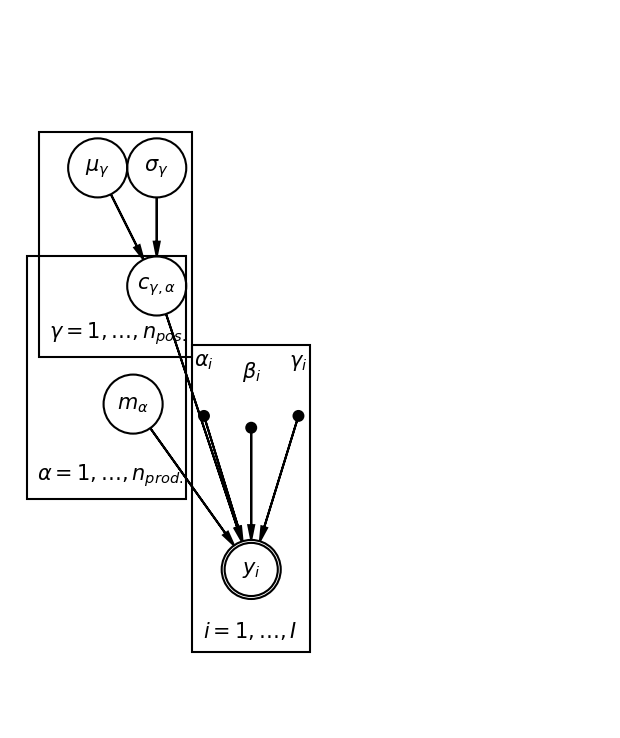

In [58]:
import daft

pgm = daft.PGM(shape=(5,6),observed_style="inner",dpi=150)

pgm.add_node('m',r'$m_{\alpha}$',1,2.7)
pgm.add_node('beta',r'$\beta_i$',2,2.5,fixed=True)
pgm.add_node('c',r'$c_{\gamma,\alpha}$',1.2,3.7)

pgm.add_node('y',r'$y_i$',2,1.3,observed=True)
pgm.add_node('alpha',r'$\alpha_i$',1.6,2.6,fixed=True)
pgm.add_node('gamma',r'$\gamma_i$',2.4,2.6,fixed=True)

#hierarchical elements
pgm.add_node('mu_c',r'$\mu_{\gamma}$',0.7,4.7)
pgm.add_node('sigma_c',r'$\sigma_{\gamma}$',1.2,4.7)


pgm.add_edge('m','y')
pgm.add_edge('beta','y')
pgm.add_edge('c','y')
pgm.add_edge('gamma','y')
pgm.add_edge('alpha','y')
pgm.add_edge('mu_c','c')
pgm.add_edge('sigma_c','c')



pgm.add_plate([1.5, 0.7, 1, 2.5], label=r"$i = 1, \ldots, I$", shift=-0.1)
pgm.add_plate([0.1, 2, 1.35, 1.95], label=r"$\alpha = 1, \ldots, n_{prod.}$", shift=-0.1)
pgm.add_plate([0.2, 3.2, 1.30, 1.8], label=r"$\gamma = 1, \ldots, n_{pos.}$", shift=-0.1)



# Render and save.
pgm.render()
pgm.show()

### Stan tips
#### Non Centred parameterisation

Rather than putting constraining the hierarchical c value like this:

`model{
c[i,j]~normal(c_hier_mean,c_hier_sig);
.....
`

it is better to carry out something called non centred parameterisation. This makes it easier for Stan to sample efficiently, for more details look in the [Stan manual](https://mc-stan.org/docs/2_22/stan-users-guide-2_22.pdf) or [Discourse group](https://discourse.mc-stan.org/). The basic premise is that the sampler samples from a standard normal distribution, which you then transform, e.g.

``model{
c_raw[i,j]~normal(0,1)
c[i,j]=c_raw[i,j]*hier_c_sig+hier_c_mean;
.....
``


In [7]:
model="""
data {
  int<lower=1> K;              // number of product places
  int<lower=1> N;              // number of observations
  vector[N] price;  //product price for observation n
  int<lower=1,upper=K> kk[N];  // product place for observation n
  int<lower=0,upper=1> y[N];   // selected or not for observation n
  int<lower=0> nprice; //number of price points
  vector[nprice] price_pred; //price points for predictions
  int<lower=1> P; //number of products
  int<lower=1> product[N]; //product for observation n
  int fit; //boolean for fitting
}

parameters {
  vector[K] c_raw[P];              // effect of place for k
  real m[P]; // slope;
  vector[K] hier_c_mean; 
  vector<lower=0.001>[K] hier_c_sig;
}

transformed parameters {
vector[K] c[P];
for (i in 1:P){
for (j in 1:K){
c[i,j]=hier_c_mean[j] +hier_c_sig[j]*c_raw[i,j];
}
}
}

model {
for (i in 1:P){
m[i] ~ std_normal();
c_raw[i] ~std_normal();
}
hier_c_mean~std_normal();
hier_c_sig~std_normal();
  
  if (fit > 0){
  for (i in 1:N){
  y[i] ~ bernoulli_logit(m[product[i]]*price[i] + c[product[i],kk[i]]);
  }
  }
}

generated quantities {
vector[N] y_rep;
matrix[nprice,K] pred_matrix[P];
matrix[nprice,K] pred_matrix_select[P];
if (fit<1){
for (i in 1:nprice){
for (j in 1:K){
for (z in 1:P){
pred_matrix[z,i,j]=m[z]*price_pred[i] + c[z,j];
pred_matrix_select[z,i,j]=bernoulli_logit_rng(pred_matrix[z,i,j]);
}
}
}
}
if (fit> 0){
for (i in 1:N){
y_rep[i] = bernoulli_logit_rng(m[product[i]]*price[i] + c[product[i],kk[i]]);
}
}
}
"""

### Analyse the Generative Ensemble
* Analyse a range of samples from generative model
* Check outputs are realistic
* Good way of checking model (especially priors) is behaving appropriately and how you expect

In [8]:
sm=pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8cd6ef74cdea45023c8aa9d89e6f989a NOW.


In [9]:
data={
    'K':5,
    'N':1,
    'price':[0],
    'kk':[1],
    'y':[1],
    'nprice':10,
    'price_pred':np.arange(-5,5,1.0),
    'P':8,
    'product':[1],
    'fit':0
}

In [10]:
fit=sm.sampling(data=data,chains=1,iter=500)

In [11]:
pystan.diagnostics.check_hmc_diagnostics(fit,verbose=3)

INFO:pystan:No divergent transitions found.
INFO:pystan:No transitions that ended prematurely due to maximum tree depth limit
INFO:pystan:Chain 1: E-BFMI (= 0.734) equals or exceeds threshold of 0.2.
INFO:pystan:E-BFMI indicated no pathological behavior


{'n_eff': False,
 'Rhat': False,
 'divergence': True,
 'treedepth': True,
 'energy': True}

Prior distribution on parameters:

<Figure size 720x720 with 0 Axes>

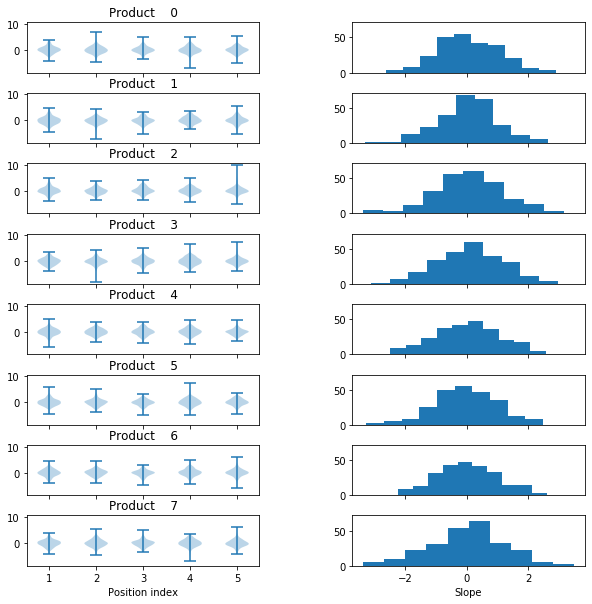

In [16]:
plt.figure(figsize=(10,10))
fig, ax = plt.subplots(fit.data['P'], 2, sharex='col', sharey='col',figsize=(10,10))
for i in range(0,fit.data['P']):
    ax[i,0].violinplot(fit['c'][:,i,:]);
    ax[i,1].hist(fit['m'][:,i]);
    ax[i,0].set_title('Product {:4.0f}'.format(i))
ax[-1,0].set_xlabel('Position index')
ax[-1,1].set_xlabel('Slope')
fig.subplots_adjust(hspace=0.4, wspace=0.4)


The intercept and slopes for the different products

## Prior Predictive distribution
Lets visualise how the chances of selection change with price and position on shelf for some of the samples from our prior predicitive distribution.

The plot below shows a heatmap of price vs position, where each column is a different product. The colours represent the chances of selection before applying the inverse logit transformation. Each row is a different sample from our prior, so can be thought of as different possible datasets.


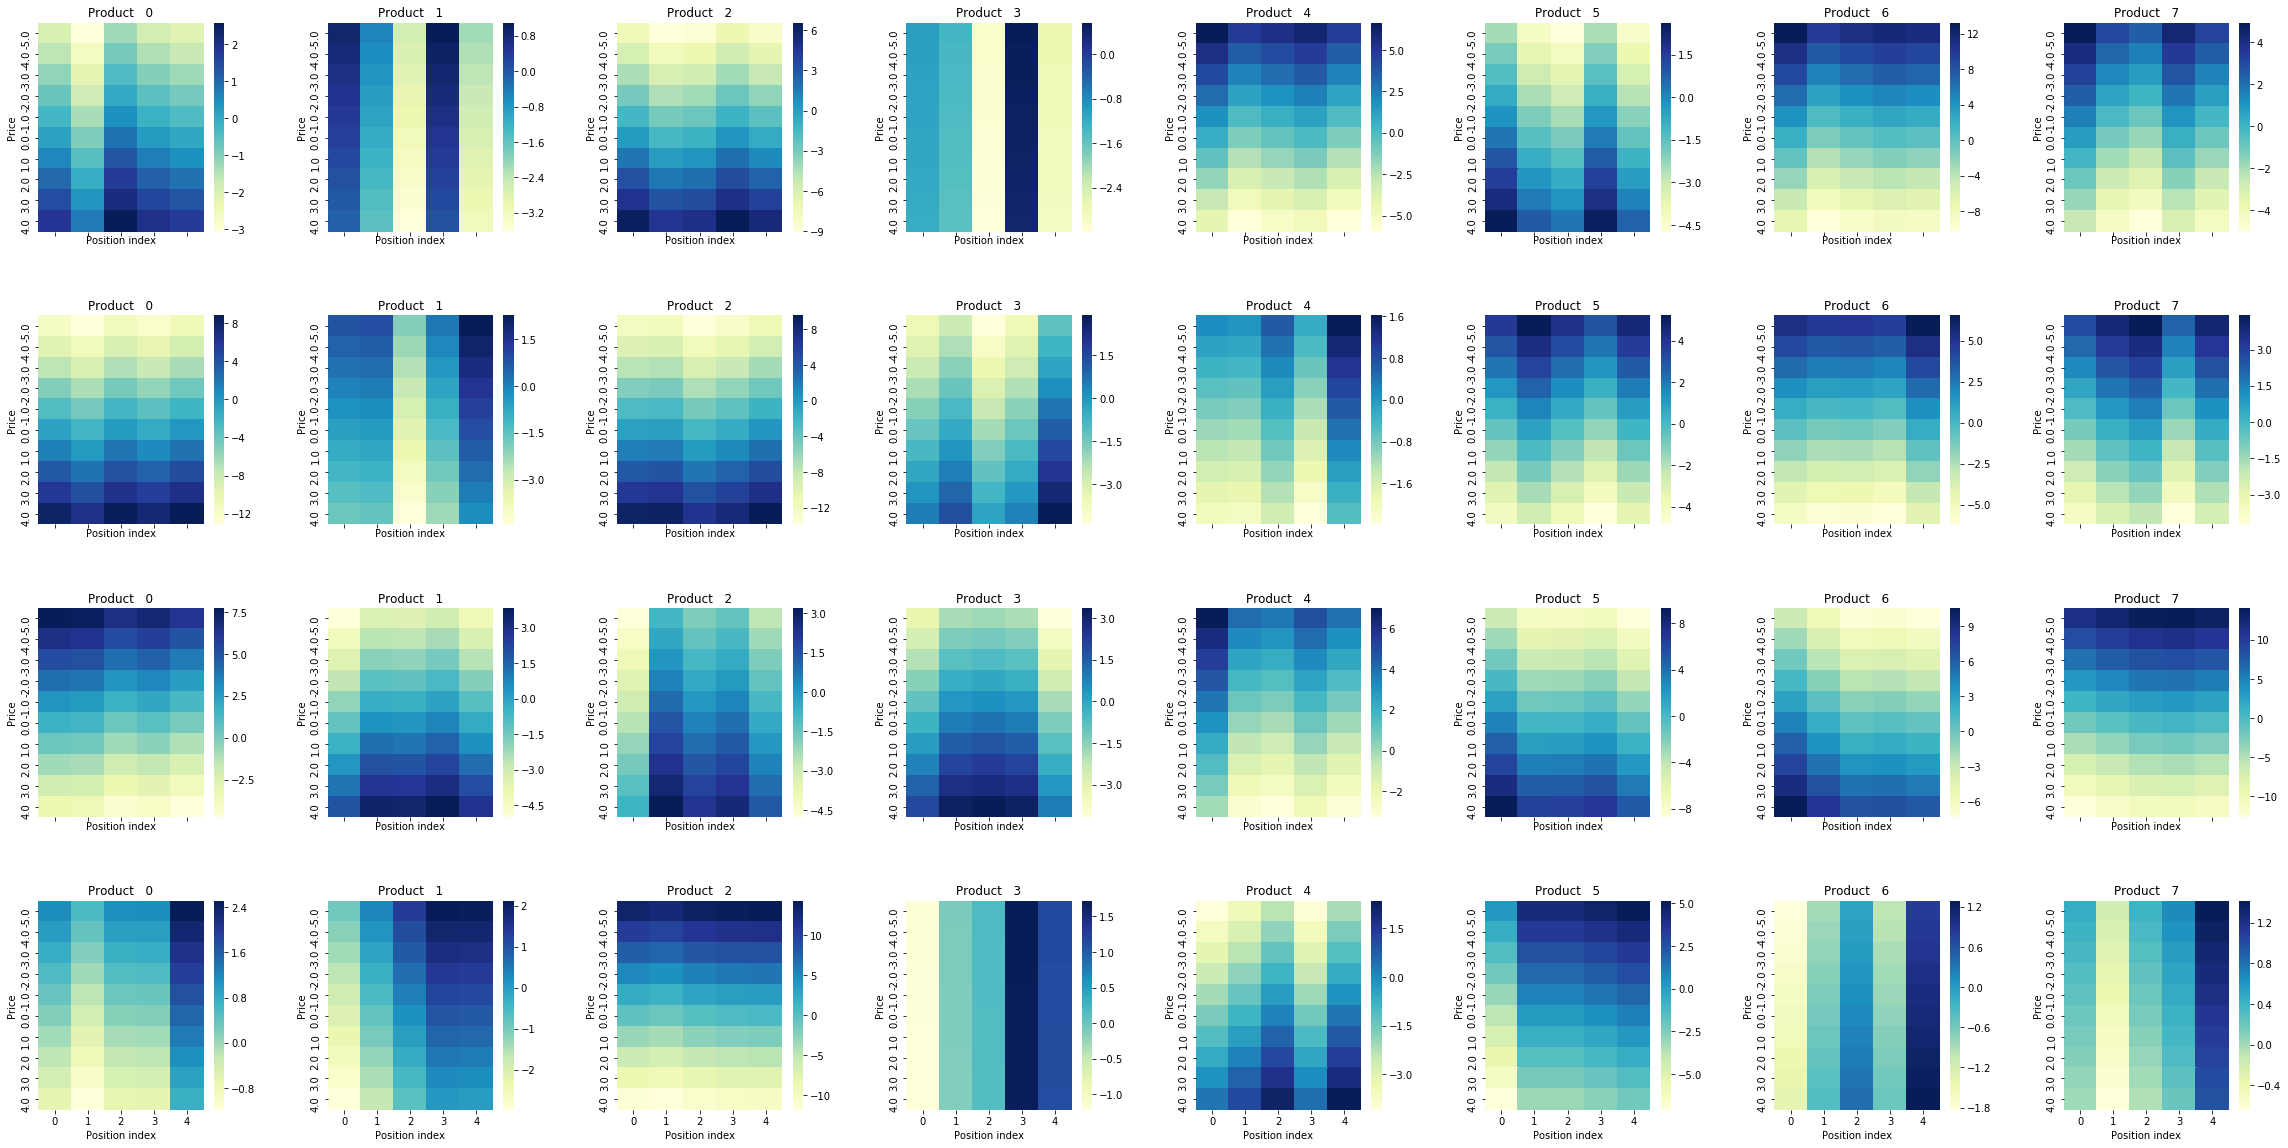

In [17]:
s=[0,1,2,10]
fig, ax = plt.subplots(len(s), fit.data['P'], sharex='col', sharey='col',figsize=(40,20))

for i in range(0,len(s)):
    for p in range(0,fit.data['P']):
        sns.heatmap(fit['pred_matrix'][s[i],p,:,:],yticklabels=fit.data['price_pred'],cmap="YlGnBu",ax=ax[i,p],)
        ax[i,p].set_xlabel('Position index')
        ax[i,p].set_ylabel('Price')
        ax[i,p].set_title(r'Product{:4.0f}'.format(p))
    #sns.heatmap(fit['pred_matrix_select'][s[i],:,:],yticklabels=fit.data['price_pred'],cmap="YlGnBu",ax=ax[i,1])

fig.subplots_adjust(hspace=0.4, wspace=0.4)


A plot showing the different prediction matrices for different products in each row. Each row is a different sample from the prior. Note how there is a similar effect from certian positions in each row. This is coming from the hierarchical prior.

Text(0.5, 0, 'positions')

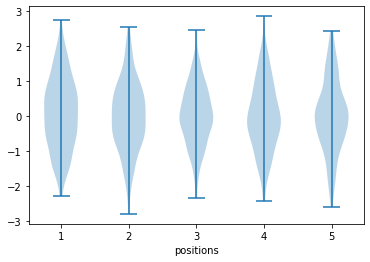

In [12]:
plt.violinplot(fit['hier_c_mean'])
plt.xlabel('positions')

The hierarchical mean values for position

## Fit prior samples

In [19]:
def zscore(posterior, truth):
    return np.abs((np.mean(posterior)-truth)/np.std(posterior))
def shrinkage(posterior,prior):
    return 1-(np.var(posterior)/np.var(prior))

In [20]:
def get_indicators(N, M, prob_std=0.5):
    ind = np.random.binomial(1, prob_std, (N, M))
    return ind>0

In [24]:
zscore_prior_pred_c=np.empty((fit.data['P'],fit.data['K'],10))
zscore_prior_pred_m=np.empty((fit.data['P'],10))
shrinkage_prior_pred_c=np.empty((fit.data['P'],fit.data['K'],10))
shrinkage_prior_pred_m=np.empty((fit.data['P'],10))
zscore_hier_mean=np.empty((fit.data['K'],10))
zscore_hier_sig=np.empty((fit.data['K'],10))
shrinkage_hier_mean=np.empty((fit.data['K'],10))
shrinkage_hier_sig=np.empty((fit.data['K'],10))


for s in range(0,10):
    data_prior={
        'K':fit.data['K'],
        'N':fit['pred_matrix'][s,:,:,:].flatten().size,
        'price':np.tile(np.repeat(np.arange(-5,5,1.0),fit.data['K']),fit.data['P']),
        'kk':np.tile(np.tile(np.arange(1,6,1),10),fit.data['P']),
        'y':fit['pred_matrix_select'][s,:,:].flatten().astype(int),
        'nprice':10,
        'price_pred':np.arange(-5,5,1.0),
        'P':8,
        'product':np.repeat(np.arange(1,fit.data['P']+1),fit.data['K']*fit.data['nprice']),
        'fit':1
        }
    fit_prior=sm.sampling(data=data_prior)
    zscore_prior_pred_c[:,:,s]=zscore(fit_prior['c'],fit['c'][s,:,:])
    for j in range(0,fit.data['P']):
        shrinkage_prior_pred_m[j,s]=shrinkage(fit_prior['m'][:,j],fit['m'][:,j])
        for i in range(0,fit.data['K']):
            shrinkage_prior_pred_c[j,i,s]=shrinkage(fit_prior['c'][:,j,i],fit['c'][:,j,i])
    zscore_prior_pred_m[:,s]=zscore(fit_prior['m'],fit['m'][s])
    zscore_hier_mean[:,s]=zscore(fit_prior['hier_c_mean'],fit['hier_c_mean'][s])
    zscore_hier_sig[:,s]=zscore(fit_prior['hier_c_sig'],fit['hier_c_sig'][s])
    for i in range(0,fit.data['K']):
        shrinkage_hier_mean[i,s]=shrinkage(fit_prior['hier_c_mean'][:,i],fit['hier_c_mean'][:,i])
        shrinkage_hier_sig[i,s]=shrinkage(fit_prior['hier_c_sig'][:,i],fit['hier_c_sig'][:,i])

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


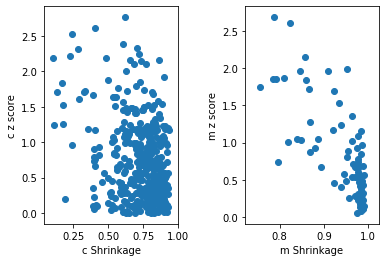

In [25]:
plt.subplot(1,2,1)
plt.scatter(shrinkage_prior_pred_c,zscore_prior_pred_c)
plt.xlabel('c Shrinkage')
plt.ylabel('c z score')
plt.subplot(1,2,2)

plt.scatter(shrinkage_prior_pred_m,zscore_prior_pred_m)
plt.xlabel('m Shrinkage')
plt.ylabel('m z score')
plt.subplots_adjust(hspace=0.5,wspace=0.5)

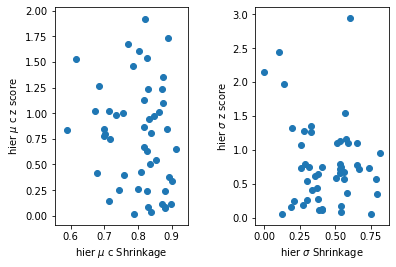

In [26]:
plt.subplot(1,2,1)
plt.scatter(shrinkage_hier_mean,zscore_hier_mean)
plt.xlabel('hier $\mu$ c Shrinkage')
plt.ylabel('hier $\mu$ c z score')
plt.subplot(1,2,2)

plt.scatter(shrinkage_hier_sig,zscore_hier_sig)
plt.xlabel('hier $\sigma$ Shrinkage')
plt.ylabel('hier $\sigma$ z score')
plt.subplots_adjust(hspace=0.5,wspace=0.5)

# Fit model to data
At the moment the model is built for one person and one product. We could assume everyone acts the same as a first pass and fit for every object.

In [28]:
data=pd.read_csv('../data/raw/priced_shelves_data.csv')
data['id.session_int']=data.groupby('id.session').grouper.group_info[0]+1
data['selected_int']=data.groupby('selected').grouper.group_info[0]
data['product_int']=data.groupby('product').grouper.group_info[0]+1
data['mean_sub_price']=data['price']-data.groupby('product').transform('mean')['price']


In [31]:
ind=data['product_int']<14

In [34]:
data_infer={
    'K':data['product_index'].unique().size,
    'N':len(data[ind]),
    'price':data[ind]['mean_sub_price'],
    'kk':data[ind]['product_index'].values+1,
    'y':data[ind]['selected_int'],
    'nprice':9,
    'price_pred':np.arange(8,17,1.0),
    'P':data[ind]['product_int'].unique().size,
    'product':data[ind]['product_int'],
    'fit':1
    }


In [35]:
fit_infer=sm.sampling(data=data_infer,chains=1,iter=500)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [36]:
pystan.check_hmc_diagnostics(fit_infer)

{'n_eff': False,
 'Rhat': False,
 'divergence': True,
 'treedepth': True,
 'energy': True}

Posterior distribution

Text(0.5, 0, 'Product index')

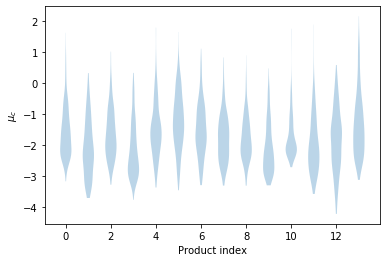

In [50]:
plt.violinplot(fit_infer['hier_c_mean'],showextrema=False,positions=data['product_index'].unique());
plt.ylabel(r'$\mu_c$');
plt.xlabel(r'Product index')

In [45]:
hier_dist=np.zeros((10,fit_infer['hier_c_mean'].shape[0],fit_infer['hier_c_mean'].shape[1]))
for i in range(0,fit_infer['hier_c_mean'].shape[0],25):
    for z in range(0,fit_infer['hier_c_mean'].shape[1]):
        hier_dist[:,i,z]=np.random.normal(fit_infer['hier_c_mean'][i,z],fit_infer['hier_c_sig'][i,z],10)

Text(0, 0.5, 'C')

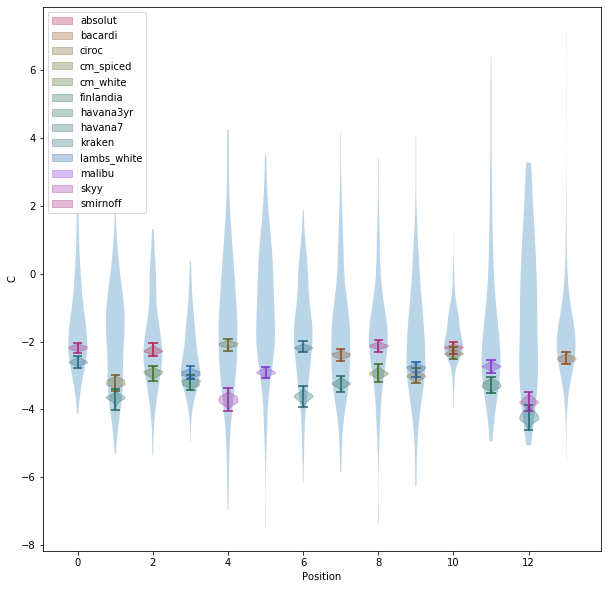

In [46]:
import matplotlib.patches as mpatches

def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))

plt.figure(figsize=(10,10))
labels=[]
c=sns.husl_palette(np.unique(fit_infer.data['product'].values).size,l=.4)
plt.violinplot(hier_dist[:,::25,:].reshape(100,14),showextrema=False,positions=data['product_index'].unique());
for z,pro in enumerate(np.unique(fit_infer.data['product'].values)):
    ind=fit_infer.data['product']==pro
    violin_parts=plt.violinplot(fit_infer['c'][:,z,np.unique(fit_infer.data['kk'][ind])-1],positions=np.unique(fit_infer.data['kk'][ind])-1);
    for pc in violin_parts['bodies']:
            pc.set_facecolor(c[z])
            pc.set_edgecolor(c[z])
    for pc in [violin_parts[i] for i in ['cbars','cmins','cmaxes']]:
            pc.set_facecolor(c[z])
            pc.set_edgecolor(c[z])
    add_label(violin_parts,np.unique(data[data['product_int']==pro]['product'])[0])
plt.legend(*zip(*labels), loc=2)
plt.xlabel('Position')
plt.ylabel('C')